In [4]:
import os
import yfinance

In [163]:
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

In [164]:
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [165]:
def multiply(a: float, b: float) -> complex:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [166]:
def add(a: float, b: float) -> complex:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [167]:
def divide(a: float, b: float) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [5]:
def get_stock_data(ticker: str) -> str:
    """Get stock data for a given ticker.

    Args:
        ticker: The stock ticker symbol.
    """
    stock_price= yfinance.Ticker(ticker)
    # print("------",stock_price.history(period="1d"))
    # return stock_price.history(period="1d").to_json()
    return stock_price.info


In [6]:
get_stock_data("AAPL")

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '(408) 996-1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and p

In [170]:
# %pip install -U duckduckgo-search

In [171]:
search = DuckDuckGoSearchRun()

In [172]:
search.invoke("who is a current president of USA?")

"The White House, official residence of the president of the United States, in 2008. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] Under the U.S. Constitution, the officeholder leads the executive branch of the federal government and is the commander-in-chief of the ... WASHINGTON − Donald Trump was sworn in Monday as the 47th president of the United States, returning to the White House after overcoming four criminal indictments and two assassination attempts ... Donald Trump takes office for his second term as the 47th president of the United States in the Rotunda of the U.S. Capitol in Washington, DC, on Monday, January 20, 2025. 1 of 39. Donald Trump, who overcame impeachments, criminal indictments and a pair of assassination attempts to win another term in the White House, was sworn in Monday as the 47th U.S. president taking ... Donald Trump has official

In [173]:
tools = [add, multiply, divide, search, get_stock_data]

In [174]:
llm_with_tools=llm.bind_tools(tools)

In [175]:
def reasoner(state):
   query = state["query"]
   messages = state["messages"]
   sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search you find the information needed to passed to the tools find in the internet for the information"
   " and performing arithmetic on a set of inputs.")
   message= HumanMessage(content=query)
   messages.append(message)
   result= [llm_with_tools.invoke([sys_msg] + state["messages"])]
   return {"messages":result}

In [ ]:
class GrahState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    messages: Annotated[list[AnyMessage], operator.add]
    result: str

In [177]:

builder = StateGraph(GrahState)

builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

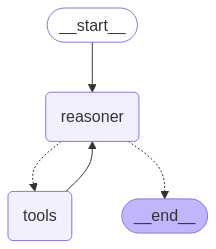

In [178]:
react_graph

In [ ]:
# messages = [HumanMessage(content="What is the result if we multiply stock price of the vedanta(Indian stock) with the 20?")]

In [182]:
messages = react_graph.invoke({"query": "What is the stock price of the microsoft","messages":[]})

In [183]:
messages

{'query': 'What is the stock price of the microsoft',
 'messages': [AIMessage(content='354.56', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 4638, 'total_tokens': 4646, 'completion_time': 0.014545455, 'prompt_time': 0.180790691, 'queue_time': 0.047459846, 'total_time': 0.195336146}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-b89cf5a6-89ca-4d2b-a18d-40c2c76c021e-0', usage_metadata={'input_tokens': 4638, 'output_tokens': 8, 'total_tokens': 4646})]}

In [184]:
for m in messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================

354.56
